# Grad-CAM (Gradient-weighted Class Activation Mapping)

##  Cel
Zrozumieć, jak działa **Grad-CAM** – technika pozwalająca zobaczyć, **które fragmenty obrazu** miały największy wpływ na decyzję modelu sieci konwolucyjnej (CNN).

---

## 📘 Wprowadzenie

Nowoczesne sieci neuronowe potrafią klasyfikować obrazy z ogromną dokładnością, jednak często są postrzegane jako „czarne skrzynki”.  
Aby zrozumieć **dlaczego** model podjął daną decyzję, wykorzystujemy metody **wizualizacji uwagi** modelu — jedną z nich jest **Grad-CAM**.

Grad-CAM (Gradient-weighted Class Activation Mapping) to metoda, która generuje **mapę cieplną (heatmap)**, pokazującą obszary na obrazie najbardziej wpływające na klasyfikację.

---

## Jak działa Grad-CAM krok po kroku

1.  **Wprowadzamy obraz** do wytrenowanego modelu CNN (np. ResNet, MobileNet, VGG16).  
2.  **Wybieramy klasę**, dla której chcemy zobaczyć, co sieć „widzi” (np. *słoń*).  
3.  **Obliczamy gradient** wyniku tej klasy względem ostatniej warstwy konwolucyjnej.  
4.  **Wyznaczamy wagi** — czyli średnie gradienty dla każdego kanału w tej warstwie.  
5.  **Tworzymy mapę cieplną**, która pokazuje, które regiony obrazu najbardziej wpływają na klasyfikację.  
6.  **Nakładamy mapę na oryginalny obraz**, aby zobaczyć, na czym „skupiła się” sieć.

---

## Wzór matematyczny

$$
L_{\text{Grad-CAM}}^c = \text{ReLU}\left(\sum_k \alpha_k^c A^k\right)
$$

gdzie:  
- $ A^k $– mapa cech z ostatniej warstwy konwolucyjnej,  
- $ \alpha_k^c $ – waga kanału $k$ dla klasy $c$, wyznaczona z gradientów,  
- ReLU – zachowuje tylko dodatnie wpływy (obszary, które zwiększają prawdopodobieństwo danej klasy).

---

## 🧠 Intuicja

- Sieć konwolucyjna uczy się wykrywać różne **cechy obrazu** – krawędzie, kształty, wzory.  
- Grad-CAM pozwala zobaczyć, **które z tych cech** były istotne przy decyzji modelu.  
- Dzięki temu możemy sprawdzić, **czy model naprawdę „patrzy” na obiekt**, czy może na tło lub inne elementy.

---

## 🔍 Zastosowania

- 📊 **Wyjaśnialność modelu** – zrozumienie, dlaczego model przypisał daną klasę.  
- 🧪 **Debugowanie sieci** – wykrywanie błędów i nadmiernego dopasowania (overfitting).  
- 🧠 **AI interpretowalna (Explainable AI)** – zwiększanie zaufania do modeli głębokiego uczenia.

---

## 📷 Przykład wizualizacji

Poniższa mapa cieplna pokazuje, że model skupił się głównie na sylwetce słonia, ignorując tło:

> Czerwone obszary → największy wpływ na decyzję  
> Niebieskie obszary → najmniejszy wpływ

---

## 🧾 Podsumowanie

**Grad-CAM** to potężne narzędzie do zrozumienia działania sieci konwolucyjnych.  
Pokazuje, *gdzie patrzy model*, i pozwala ocenić, *czy jego decyzje są logiczne i uzasadnione.*

---

> 💡 **W skrócie:**  
> Grad-CAM = gradienty + aktywacje → mapa cieplna, która pokazuje uwagę modelu.


## CZĘŚĆ 2: Praktyka — Grad-CAM krok po kroku

In [9]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, ResNet50, VGG16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2


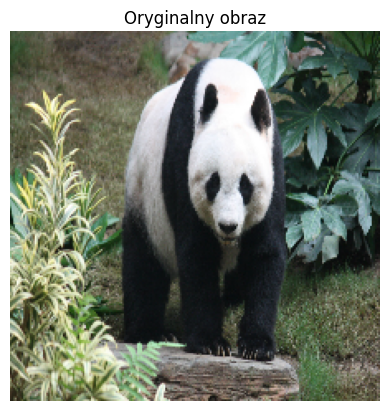

In [10]:
img_path = "../panda.png"  # lokalny plik w katalogu roboczym
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.title("Oryginalny obraz")
plt.axis("off")
plt.show()


In [11]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)


In [12]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [13]:
def display_gradcam(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step

Model: MobileNetV2
Predykcja: [('n02510455', 'giant_panda', np.float32(0.9709899))]


c:\Users\jakub\workspace\SWPS_2\venv\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_712']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


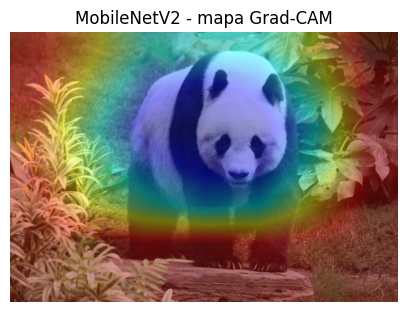

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step

Model: ResNet50
Predykcja: [('n01930112', 'nematode', np.float32(0.091687635))]


c:\Users\jakub\workspace\SWPS_2\venv\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_868']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


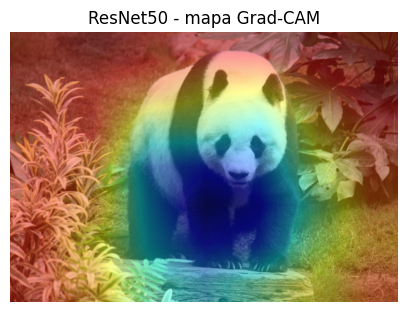

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step

Model: VGG16
Predykcja: [('n03788365', 'mosquito_net', np.float32(0.08446243))]


c:\Users\jakub\workspace\SWPS_2\venv\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_1045']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


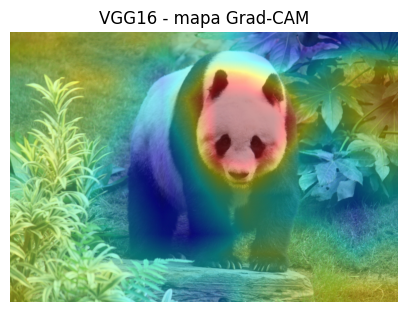

In [14]:
models = {
    "MobileNetV2": (MobileNetV2(weights="imagenet"), "Conv_1"),
    "ResNet50": (ResNet50(weights="imagenet"), "conv5_block3_out"),
    "VGG16": (VGG16(weights="imagenet"), "block5_conv3"),
}

for name, (model, layer) in models.items():
    preds = model.predict(x)
    print(f"\nModel: {name}")
    print("Predykcja:", decode_predictions(preds, top=1)[0])

    heatmap = make_gradcam_heatmap(x, model, layer)
    plt.figure(figsize=(5, 5))
    plt.title(f"{name} - mapa Grad-CAM")
    display_gradcam(img_path, heatmap)


### Analiza wyników
- MobileNetV2: szybki, lekki model, mapa mniej szczegółowa.
- ResNet50: bardziej precyzyjne uwzględnienie kształtu.
- VGG16: klasyczny model, często podkreśla duże obszary obiektu.
